In [38]:
# Set up libraries and backend
from qiskit.tools.jupyter import * 
from qiskit import IBMQ
from qiskit import assemble
import numpy as np
import matplotlib.pyplot as plt
from qiskit import pulse
from qiskit.pulse import pulse_lib
from qiskit.pulse import Play
from qiskit.pulse.commands import SamplePulse
from qiskit.tools.monitor import job_monitor
from scipy.optimize import curve_fit
import json

%config InlineBackend.figure_format = 'svg'
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

# Use for conversions later
GHz = 1.0e9
MHz = 1.0e6
kHz = 1.0e3
ms = 1.0e-3
us = 1.0e-6
ns = 1.0e-9
scale_factor = 1e-14

# Initialize qubit to |0> and retrieve backend frequencies
qubit = 0
dt = backend_config.dt
backend_defaults = backend.defaults()
qubit_props_dict = backend.properties().qubit_property(0)
rough_qubit_freq = qubit_props_dict['frequency'][0]
rough_cav_freq = backend_defaults.meas_freq_est[qubit]


# Define and configure measurement map (hardware constraint)
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in meas_map!"
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)
qubit_meas_group = backend_config.meas_map[meas_map_idx]
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=qubit_meas_group)


# Define for convenience
def get_closest_multiple_of_16(num):
    return int(num + 8) - (int(num + 8) % 16)
    
# Save and retrieve data from external text files
def save_data(dataset, file):
    filehandler = open(file, 'w')
    json.dump(dataset, filehandler)
    filehandler.close()

def load_data(file):
    filehandler = open(file)
    dataset = json.load(filehandler)
    filehandler.close()
    return dataset

# Get list of data points (complex-valued) from result of job
def get_job_data(job):
    sweep = []
    result = job.result(timeout=120)
    for i in range(len(result.results)):
        res = result.get_memory(i)*scale_factor
        sweep.append(res[qubit])
    return sweep

# Define curve fitting function
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev=5000)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

ibmqfactory.load_account:WARNING:2020-08-20 21:58:30,006: Credentials are already in use. The existing account in the session will be replaced.


In [39]:
# Design cavity drive pulses (varying amplitude for each job, other parameters constant)
cav_amp_min = 0.0
cav_amp_max = 1.0
num_amps = 11
cav_amps = np.linspace(cav_amp_min, cav_amp_max, num_amps, endpoint=True)

risefall_us = 0.01
sigma_us = 0.01
dur_us = 3.0

risefall = get_closest_multiple_of_16(risefall_us * us/dt)
sigma = get_closest_multiple_of_16(sigma_us * us/dt)
dur = get_closest_multiple_of_16(dur_us * us/dt)

In [40]:
# Configure sweep range for each decay (so that each decay can be fit properly by fit_function)
that_data = load_data('QubitLifetimeVsCavityDriveSweep.txt')

optimal_max = that_data['optimal_end_times'] # List of approximate decay times from calibration experiment
max_times_list = []
for amp in cav_amps:
    if (amp == 0.0): # Case with no drive drive
        max_times_list.append(450)
    else:
        key = str(amp)[:3] # 3 digits of precision
        val = optimal_max[key]
        max_times_list.append(val)

max_times_us = np.asarray(max_times_list)
all_times_us = []
all_times_dt = []
num_times = 50
time_min_us = 5

# For each cav drive, generate an array of sample times from time_min_us to the specific max
for time_max_us in max_times_us:
    times_us = np.linspace(time_min_us, time_max_us, num_times)
    delay_times_dt = [get_closest_multiple_of_16(time * us / dt) for time in times_us]
    all_times_us.append(times_us)
    all_times_dt.append(delay_times_dt)

In [41]:
# Design pi pulse
pi_data = load_data('pipulse.txt')
pi_amp = pi_data["pi_amp"] # from calibration experiment
drive_sigma_us = pi_data["drive_sigma_us"] # Width of the gaussian pulse
drive_samps_us = pi_data["drive_samps_us"] # Truncates duration of gaussian to be finite

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)   # Puts width in units of dt
drive_samps = get_closest_multiple_of_16(drive_samps_us * us /dt)   # Puts duration in units of dt
pi_pulse = pulse_lib.gaussian(duration=drive_samps, amp=pi_amp, 
                              sigma=drive_sigma, name='pi_pulse')

In [42]:
no_pi_programs = [] # Cav drive + measure (ground state)
pi_programs = [] # Cav drive + pi pulse + measure (excited state)
num_shots = 256

for i in range(len(cav_amps)):
    if (cav_amps[i] != 0.0): # No need to create pulse for 0 amp drive
        cav_pulse = pulse_lib.gaussian_square(amp=cav_amps[i], sigma=sigma, duration=dur, risefall=risefall)
    
    no_pi_schedules = []
    
    for delay in all_times_dt[i]:
        no_pi_schedule = pulse.Schedule()
        if (cav_amps[i] != 0.0):
            no_pi_schedule += Play(cav_pulse, meas_chan)
        no_pi_schedule += measure << int(delay) + drive_samps # Adjust so (start of acq) - (end of pi pulse) = delay
        no_pi_schedules.append(no_pi_schedule)
    
    pi_schedules = []
    
    for delay in all_times_dt[i]:
        pi_schedule = pulse.Schedule()
        if (cav_amps[i] != 0.0):
            pi_schedule += Play(cav_pulse, meas_chan)
        pi_schedule += Play(pi_pulse, drive_chan) # Excite qubit while cavity is in driven state
        pi_schedule += measure << int(delay) + drive_samps
        pi_schedules.append(pi_schedule)
    
    no_pi_program = assemble(no_pi_schedules, backend=backend, meas_level=1, meas_return='avg', shots=num_shots,
                            schedule_los=[{drive_chan: rough_qubit_freq}] * len(no_pi_schedules))
    
    pi_program = assemble(pi_schedules, backend=backend, meas_level=1, meas_return='avg', shots=num_shots,
                         schedule_los=[{drive_chan: rough_qubit_freq}] * len(pi_schedules))
    
    
    no_pi_programs.append(no_pi_program)
    pi_programs.append(pi_program)

In [43]:
# function to average results of many jobs for same program (# jobs = 'trials', # data points/job = 'num_values')
def many_jobs_data(program, trials, num_values):
    sum_data = np.zeros(num_values, dtype="complex128")
    count = 0 # counter to keep track during for loop (function prints iteration)
    for i in range(trials):
        count += 1
        job = backend.run(program)
        print(f"Job {count} has ID: {job.job_id()}")
        job_monitor(job)
        print(f"Error message: {job.error_message()}")        
        values = get_job_data(job)
        sum_data += np.asarray(values)
    
    return (sum_data/trials) # returns avg over all jobs run

In [44]:
no_pi_sweeps = []
pi_sweeps = []

for i in range(len(no_pi_programs)):
    no_pi_data = many_jobs_data(no_pi_programs[i], 3, num_times)
    pi_data = many_jobs_data(pi_programs[i], 3, num_times)
    
    no_pi_sweeps.append(no_pi_data)
    pi_sweeps.append(pi_data)

Job 1 has ID: 5f3f2a4d1e7af100129808ae
Job Status: job has successfully run
Error message: None
Job 2 has ID: 5f3f2aa905d17a0014edc788
Job Status: job has successfully run
Error message: None
Job 3 has ID: 5f3f2ac7ef910e0012bcbf00
Job Status: job has successfully run
Error message: None
Job 1 has ID: 5f3f2ae5f668140012eeee1d
Job Status: job has successfully run
Error message: None
Job 2 has ID: 5f3f2b03289ceb0013d7cb19
Job Status: job has successfully run
Error message: None
Job 3 has ID: 5f3f2b2205d17a0014edc78d
Job Status: job has successfully run
Error message: None
Job 1 has ID: 5f3f2b424727e500140ec18e
Job Status: job has successfully run
Error message: None
Job 2 has ID: 5f3f2b60474efe001553f8fb
Job Status: job has successfully run
Error message: None
Job 3 has ID: 5f3f2b7ef668140012eeee28
Job Status: job has successfully run
Error message: None
Job 1 has ID: 5f3f2b9c05d17a0014edc794
Job Status: job has successfully run
Error message: None
Job 2 has ID: 5f3f2bbcef910e0012bcbf0d
J

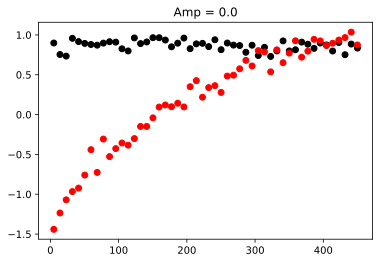

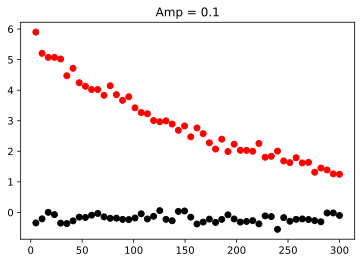

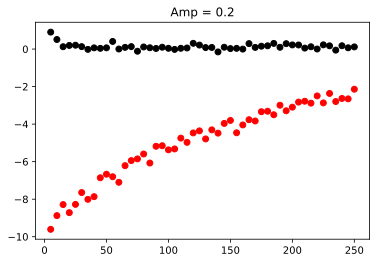

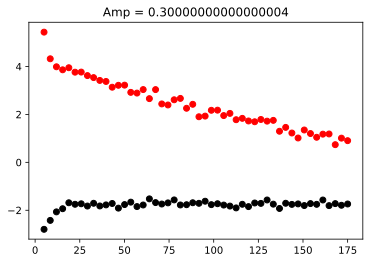

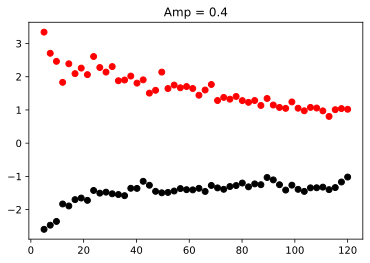

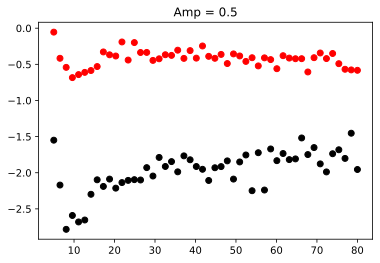

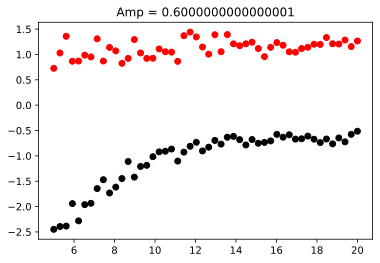

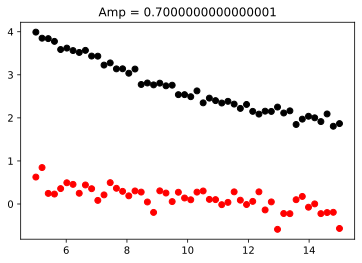

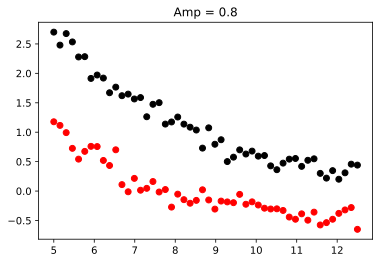

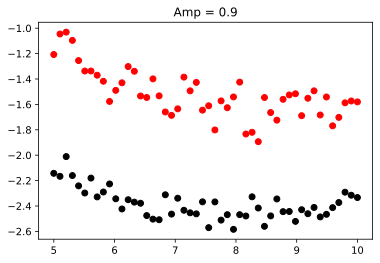

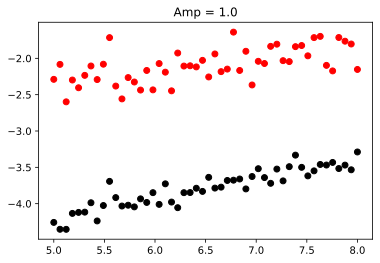

In [54]:
# Plot data over all relevant times for each cav drive amp
for i in range(len(no_pi_sweeps)):
    plt.scatter(all_times_us[i], no_pi_sweeps[i], color='black')
    plt.scatter(all_times_us[i], pi_sweeps[i], color='red')
    plt.title(f"Amp = {cav_amps[i]}")
    plt.show()

In [64]:
# Observe 'better' decay windows for each amp based on results, store in dict
mod_optimal_max = {'0.0': 450, '0.1': 300, '0.2': 250, '0.3': 200, '0.4': 175, '0.5': 100, '0.6': 10, '0.7': 7, 
                   '0.8': 7, '0.9': 7, '1.0': 7}

mod_max_times_list = []
for amp in cav_amps:
    key = str(amp)[:3]
    val = mod_optimal_max[key]
    mod_max_times_list.append(val)

mod_max_times_us = np.asarray(mod_max_times_list)
mod_all_times_us = []
mod_all_times_dt = []
num_times = 50
time_min_us = 5

# Adjust decay windows
for time_max_us in mod_max_times_us:
    times_us = np.linspace(time_min_us, time_max_us, num_times)
    delay_times_dt = [get_closest_multiple_of_16(time * us / dt) for time in times_us]
    mod_all_times_us.append(times_us)
    mod_all_times_dt.append(delay_times_dt)
    

In [65]:
# Rerun same protocol
mod_no_pi_programs = []
mod_pi_programs = []
num_shots = 256

for i in range(len(cav_amps)):
    if (cav_amps[i] != 0.0):
        cav_pulse = pulse_lib.gaussian_square(amp=cav_amps[i], sigma=sigma, duration=dur, risefall=risefall)
    
    mod_no_pi_schedules = []
    
    for delay in mod_all_times_dt[i]:
        mod_no_pi_schedule = pulse.Schedule()
        if (cav_amps[i] != 0.0):
            mod_no_pi_schedule += Play(cav_pulse, meas_chan)
        mod_no_pi_schedule += measure << int(delay) + drive_samps
        mod_no_pi_schedules.append(mod_no_pi_schedule)
    
    mod_pi_schedules = []
    
    for delay in mod_all_times_dt[i]:
        mod_pi_schedule = pulse.Schedule()
        if (cav_amps[i] != 0.0):
            mod_pi_schedule += Play(cav_pulse, meas_chan)
        mod_pi_schedule += Play(pi_pulse, drive_chan)
        mod_pi_schedule += measure << int(delay) + drive_samps
        mod_pi_schedules.append(mod_pi_schedule)
    
    mod_no_pi_program = assemble(mod_no_pi_schedules, backend=backend, meas_level=1, meas_return='avg', shots=num_shots,
                            schedule_los=[{drive_chan: rough_qubit_freq}] * len(mod_no_pi_schedules))
    
    mod_pi_program = assemble(mod_pi_schedules, backend=backend, meas_level=1, meas_return='avg', shots=num_shots,
                         schedule_los=[{drive_chan: rough_qubit_freq}] * len(mod_pi_schedules))
    
    
    mod_no_pi_programs.append(mod_no_pi_program)
    mod_pi_programs.append(mod_pi_program)

In [66]:
mod_no_pi_sweeps = []
mod_pi_sweeps = []

for i in range(len(mod_no_pi_programs)):
    mod_no_pi_data = many_jobs_data(mod_no_pi_programs[i], 5, num_times)
    mod_pi_data = many_jobs_data(mod_pi_programs[i], 5, num_times)
    
    mod_no_pi_sweeps.append(mod_no_pi_data)
    mod_pi_sweeps.append(mod_pi_data)

Job 1 has ID: 5f401d011e7af1001298140c
Job Status: job has successfully run
Error message: None
Job 2 has ID: 5f401d19959027001275f197
Job Status: job has successfully run
Error message: None
Job 3 has ID: 5f401d314727e500140eccec
Job Status: job has successfully run
Error message: None
Job 4 has ID: 5f401d48f668140012eef9b0
Job Status: job has successfully run
Error message: None
Job 5 has ID: 5f401d60ef910e0012bcca5c
Job Status: job has successfully run
Error message: None
Job 1 has ID: 5f401d78289ceb0013d7d6ae
Job Status: job has successfully run
Error message: None
Job 2 has ID: 5f401d90804d6b0012ef0e69
Job Status: job has successfully run
Error message: None
Job 3 has ID: 5f401daa34e831001202598a
Job Status: job has successfully run
Error message: None
Job 4 has ID: 5f401dc405d17a0014edd31b
Job Status: job has successfully run
Error message: None
Job 5 has ID: 5f401ddd474efe0015540495
Job Status: job has successfully run
Error message: None
Job 1 has ID: 5f401e28474efe001554049a
J

Job Status: job has successfully run
Error message: None
Job 2 has ID: 5f40284d05d17a0014edd3cf
Job Status: job has successfully run
Error message: None
Job 3 has ID: 5f40288605d17a0014edd3d3
Job Status: job has successfully run
Error message: None
Job 4 has ID: 5f4028bff668140012eefa54
Job Status: job has successfully run
Error message: None
Job 5 has ID: 5f402907ef910e0012bccb0f
Job Status: job has successfully run
Error message: None
Job 1 has ID: 5f402949289ceb0013d7d74b
Job Status: job has successfully run
Error message: None
Job 2 has ID: 5f402974289ceb0013d7d74e
Job Status: job has successfully run
Error message: None
Job 3 has ID: 5f4029934727e500140ecd97
Job Status: job has successfully run
Error message: None
Job 4 has ID: 5f4029ba05d17a0014edd3dd
Job Status: job has successfully run
Error message: None
Job 5 has ID: 5f402a02f668140012eefa5e
Job Status: job has successfully run
Error message: None
Job 1 has ID: 5f402ace959027001275f25a
Job Status: job has successfully run
Err

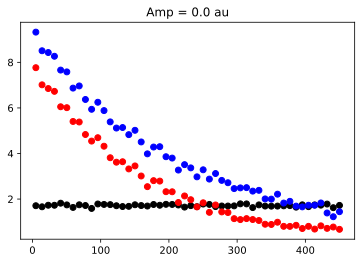

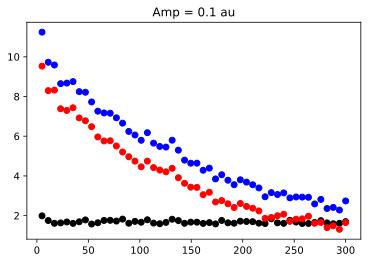

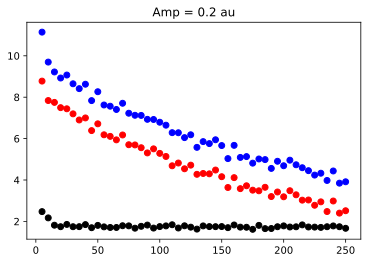

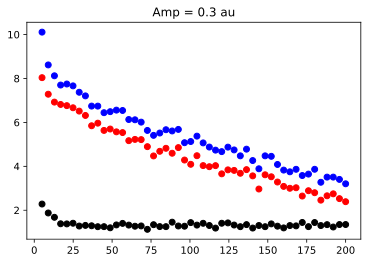

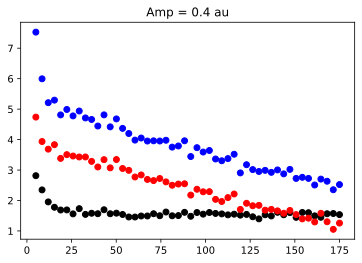

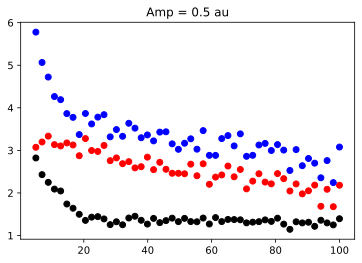

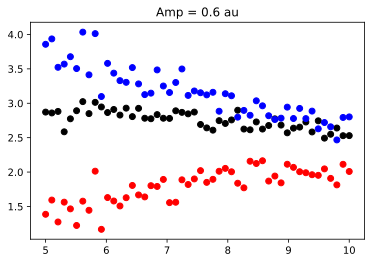

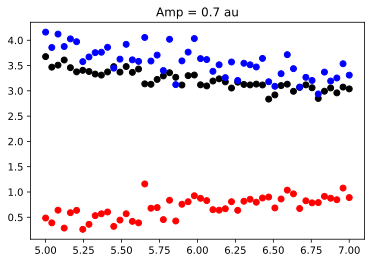

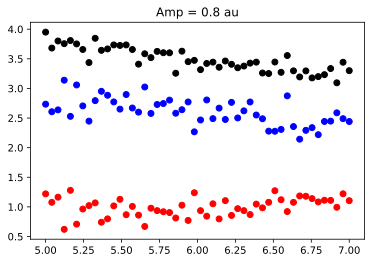

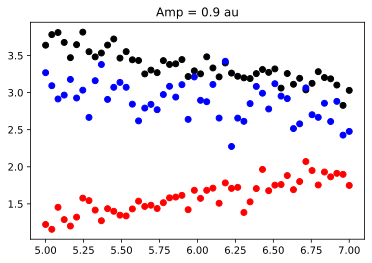

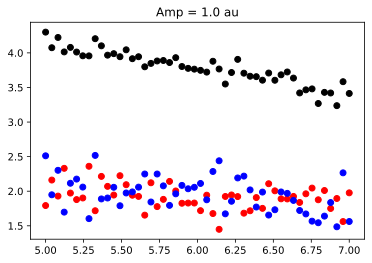

In [79]:
mod_sweep_diffs = [] # for storing the difference between exc and gnd state results w/ same drive

# Plot results for gnd and exc states with difference curve (which is more accurate estimate of T1 decay 
# since it has control shift from gnd state built in)
for i in range(len(mod_no_pi_sweeps)):
    plt.scatter(mod_all_times_us[i], np.abs(mod_no_pi_sweeps[i]), color='black')
    plt.scatter(mod_all_times_us[i], np.abs(mod_pi_sweeps[i]), color='red')
    mod_sweep_diff = mod_pi_sweeps[i] - mod_no_pi_sweeps[i]
    plt.scatter(mod_all_times_us[i], np.abs(mod_sweep_diff), color='blue')
    plt.title(f"Amp = {str(cav_amps[i])[:3]} au")
    plt.show()
    
    mod_sweep_diffs.append(mod_sweep_diff)

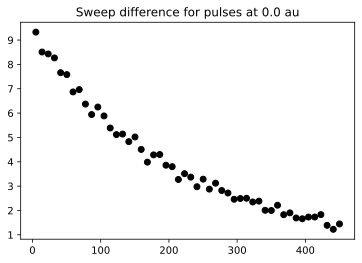

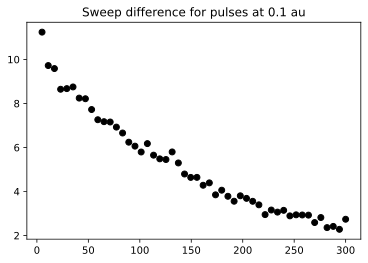

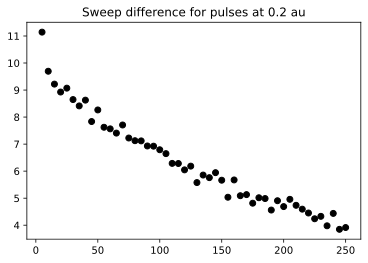

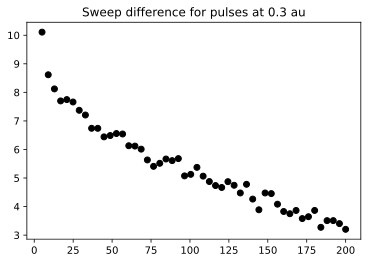

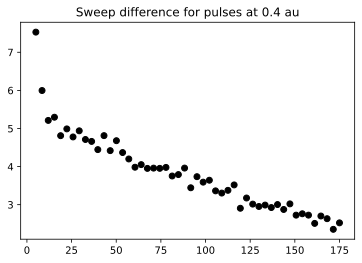

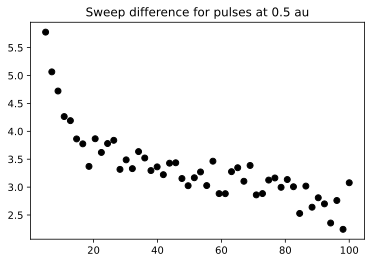

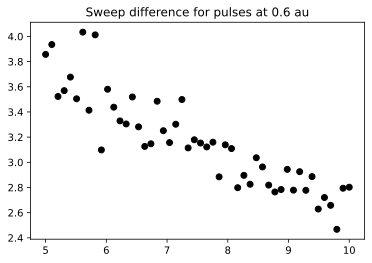

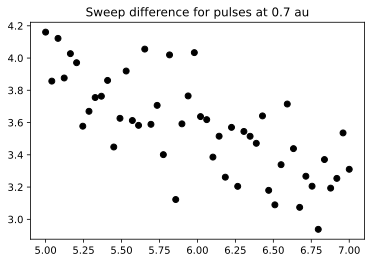

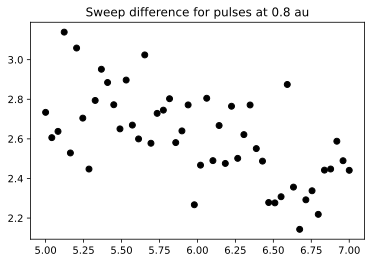

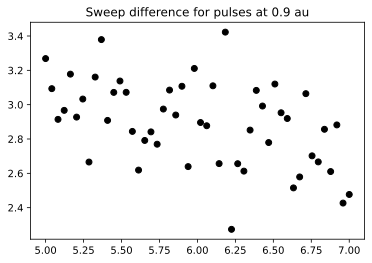

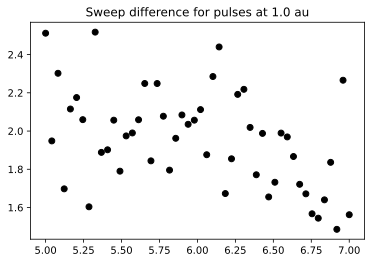

In [78]:
# Plot only abs value of difference curves
for i in range(len(mod_sweep_diffs)):
    plt.scatter(mod_all_times_us[i], np.abs(mod_sweep_diffs[i]), color='black')
    plt.title(f"Sweep difference for pulses at {str(cav_amps[i])[:3]} au")
    plt.show()

11


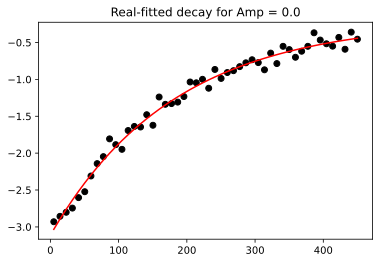

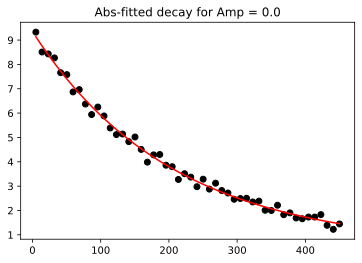

11


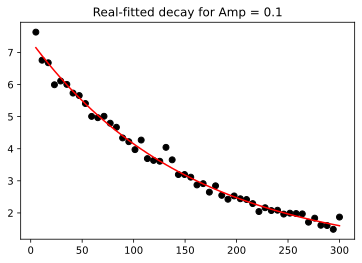

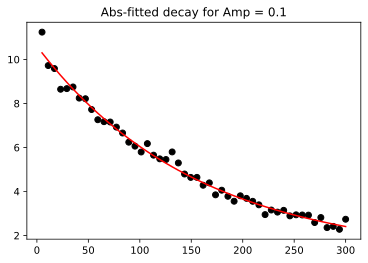

11


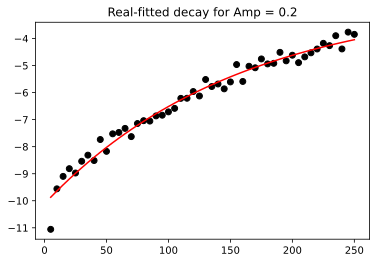

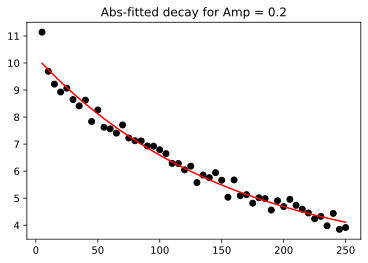

11


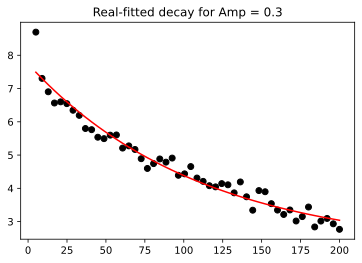

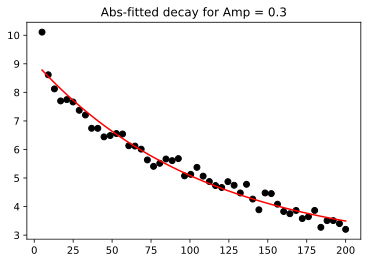

11


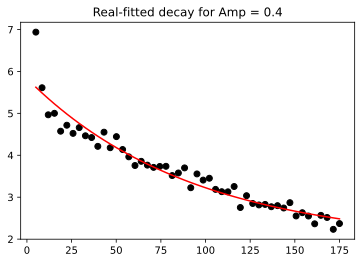

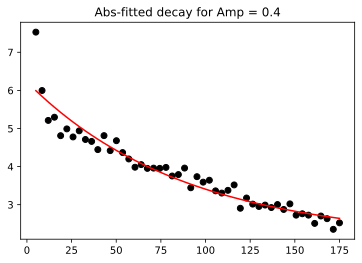

11


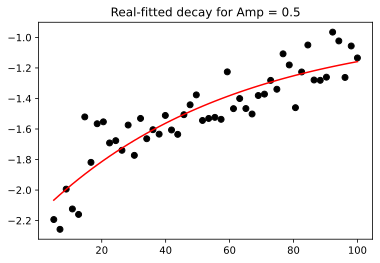

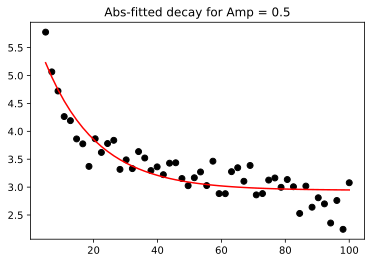

11


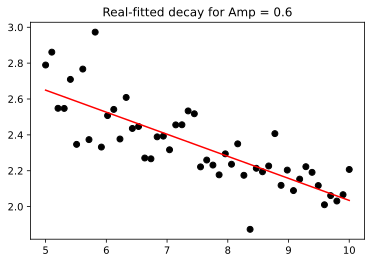

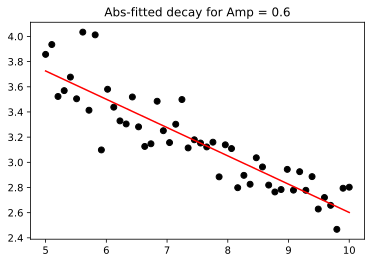

11


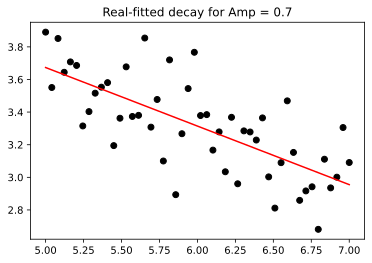

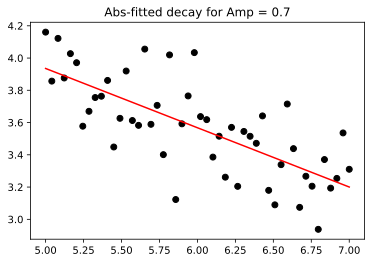

11


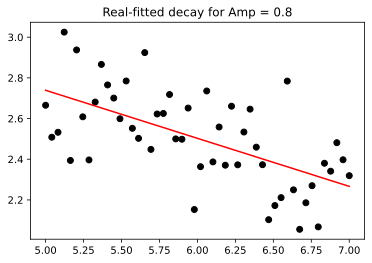

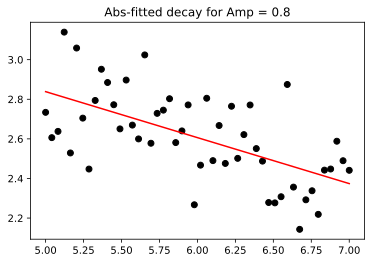

11


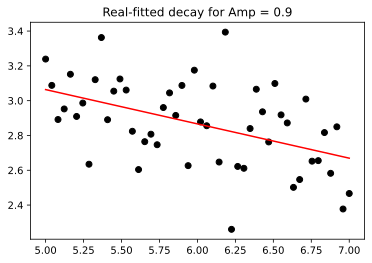

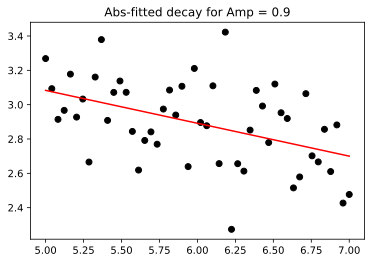

11


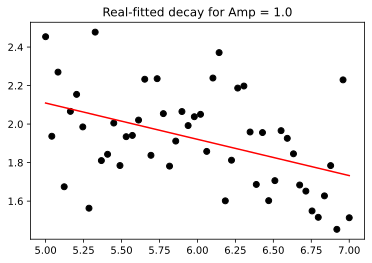

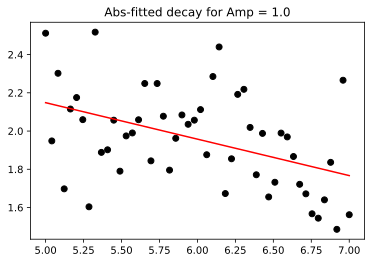

[180.56155541793282, 153.57228675097866, 155.9465959333039, 109.41145939386014, 92.32781210650913, 60.22286197557955, -31744.523000210822, -6229.110824234628, 9853.98298447957, 35785.42034042951, 26453.59051492766] [203.11690746098336, 154.40900867251716, 154.00434765342186, 109.1414458029872, 88.35134463674834, 16.329641916808892, -23803.649163284383, -27575.20439201381, 15493.081129914448, 52069.7590993341, 28544.978772425195]


In [90]:
# For each amp-dependent diff curve, fit real + abs value of data separately (they give diff decay rates)
real_sweep_diff_T1s = [] # real decay rates 
mag_sweep_diff_T1s = [] # mag decay rates

for i in range(len(mod_sweep_diffs)):
    print(count)
    # Fit both to simple exponential decays
    real_params, real_fit = fit_function(mod_all_times_us[i], np.real(mod_sweep_diffs[i]),
                              lambda x, A, C, T1: (A * np.exp(-x / T1) + C), [10, 0, 50])
    
    mag_params, mag_fit = fit_function(mod_all_times_us[i], np.abs(mod_sweep_diffs[i]),
                              lambda x, A, C, T1: (A * np.exp(-x / T1) + C), [10, 0, 50])
    _, _, real_T1 = real_params
    _, _, mag_T1 = mag_params
    
    # Plot both real + mag curves with fits to confirm accuracy
    plt.scatter(mod_all_times_us[i], np.real(mod_sweep_diffs[i]), color='black')
    plt.plot(mod_all_times_us[i], real_fit, color='red')
    plt.title(f"Real-fitted decay for Amp = {str(cav_amps[i])[:3]}")
    plt.show()

    plt.scatter(mod_all_times_us[i], np.abs(mod_sweep_diffs[i]), color='black')
    plt.plot(mod_all_times_us[i], mag_fit, color='red')
    plt.title(f"Abs-fitted decay for Amp = {str(cav_amps[i])[:3]}")
    plt.show()
    
    real_sweep_diff_T1s.append(real_T1)
    mag_sweep_diff_T1s.append(mag_T1)
    
print(real_sweep_diff_T1s, mag_sweep_diff_T1s)

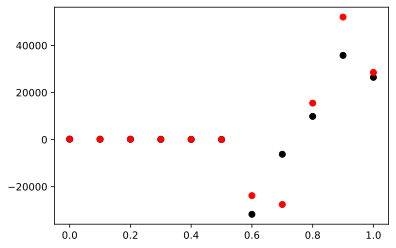

In [94]:
# Plot real/mag T1s as function of cav drive amp
plt.scatter(cav_amps, real_sweep_diff_T1s, color='black')
plt.scatter(cav_amps, mag_sweep_diff_T1s, color='red')
plt.title('T1 as a Function of Drive Amplitude')
plt.xlabel('Cavity Drive Amplitude [a.u.]')
plt.ylabel('T1 [us]')
plt.show()

In [97]:
# Cleaning function that removes values past a given magnitude
def remove_points_outside(xdata, ydata, thresh):
    new_xdata = []
    new_ydata = []
    for i in range(len(xdata)):
        if (abs(ydata[i]) < thresh):
            new_xdata.append(xdata[i])
            new_ydata.append(ydata[i])
    return np.asarray(new_xdata), new_ydata

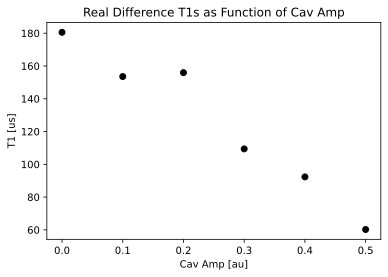

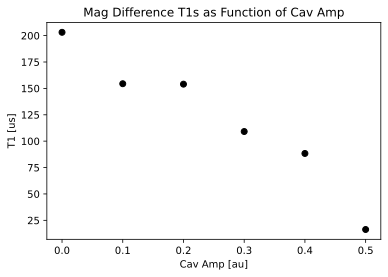

In [101]:
# Remove outlying T1s (improper fits generate massive T1s)
resized_real_cav_amps, resized_real_sweep_diff_T1s = remove_points_outside(cav_amps, real_sweep_diff_T1s, 1000)
resized_mag_cav_amps, resized_mag_sweep_diff_T1s = remove_points_outside(cav_amps, mag_sweep_diff_T1s, 1000)

# Replot
plt.scatter(resized_real_cav_amps, resized_real_sweep_diff_T1s, color='black')
plt.title("Real Difference T1s as Function of Cav Amp")
plt.xlabel("Cav Amp [au]")
plt.ylabel("T1 [us]")
plt.show()

plt.scatter(resized_mag_cav_amps, resized_mag_sweep_diff_T1s, color='black')
plt.title("Mag Difference T1s as Function of Cav Amp")
plt.xlabel("Cav Amp [au]")
plt.ylabel("T1 [us]")
plt.show()

In [102]:
# Store data externally
this_data = {'cav_amps': cav_amps.tolist(), 'cav_dur_us': dur_us, 'num_times': num_times, 'time_min_us': time_min_us,
            'optimal_max_times_us': mod_optimal_max, 'real_sweep_diff_T1s': real_sweep_diff_T1s, 
            'mag_sweep_diff_T1s': mag_sweep_diff_T1s, 'resized_real_cav_amps': resized_real_cav_amps.tolist(),
            'resized_mag_cav_amps': resized_mag_cav_amps.tolist(), 
            'resized_real_sweep_diff_T1s': resized_real_sweep_diff_T1s,
            'resized_mag_sweep_diff_T1s': resized_mag_sweep_diff_T1s}

save_data(this_data, 'QubitLifetimeVsPulseAmplitudeSweepVaryPiPulse.txt')
save_data(this_data, 'QubitLifetimeVsPulseAmplitudeSweepVaryPiPulse_1.txt')